# Clustering for gevtev

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.neighbors import DistanceMetric
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import cluster
from sklearn.decomposition.pca import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
#path_to_gamma_bins shoud contain an absolute path to your gamma-bins directory
path_to_gamma_bins = os.path.dirname(os.getcwd()) + "/"

In [3]:
#name columns included in the final display
other_names = ['gev_1FGL_Name', 'gev_CLASS1', 'tev_fermi_names', 'tev_classes', 'marked']
#from gamma bins directory
path_to_catalog = "markeddata/gevtev_TeVspectrum_normalized.txt"

In [4]:
spectra = pd.read_csv(path_to_gamma_bins +path_to_catalog)
spectra.head()

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,0.055155,0.201477,0.000004,0.235066,0.028249,0.0,0.391619,0.072841,0.013193,0.002028,0.000367,b' ',b'bll ',b'',b'hbl',0
1,0.069119,0.073172,0.003407,0.038325,0.145615,0.0,0.134071,0.020429,0.006452,0.059379,0.450031,b' ',b'snr ',b'',b'snr',0
2,0.358190,0.178179,0.096737,0.268908,0.097987,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0
3,0.269005,0.157462,0.139724,0.220561,0.213247,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0
4,0.427725,0.147237,0.104148,0.231066,0.089825,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0


In [5]:
spectrum_columns = spectra.columns[:-len(other_names)]

In [6]:
def get_distance_metric(metric_function):
    if type(metric_function) == str:
        dist = DistanceMetric.get_metric(metric_function)
    else:
        dist = DistanceMetric.get_metric("pyfunc", func=metric_function)
    return dist

In [7]:
def build_images(spectra_distances, TSNE_learning_rate=500, TSNE_n_iter=1500, TSNE_learning_rate2=300):
    colors = ['red','black']
    c = spectra['marked'].apply(lambda x: colors[x])

    plt.subplots(figsize=(18, 6))
    plt.subplot(131)
    plt.title("PCA")
    pca = PCA(n_components=2, random_state=42)
    spectra_2D = pca.fit_transform(spectra[spectrum_columns])
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.subplot(132)
    plt.title("TSNE, Euclidean distance")
    tsne = TSNE(n_components=2, random_state=42, learning_rate=TSNE_learning_rate, n_iter=TSNE_n_iter)
    spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.subplot(133)
    plt.title("TSNE, Chosen distance")
    tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=TSNE_learning_rate2)
    spectra_2D = tsne.fit_transform(spectra_distances)
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
    plt.show()
    
    
    # visualization - tsne with chosen distance
    print('Clustering')
    plt.subplots(figsize=(18, 12))
    plt.subplot(3, 3, 1)

    colors = ['red','black']
    c = spectra['marked'].apply(lambda x: colors[x])
    plt.title("true labels")
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

    for n in range(2, 10):
        kmeans = cluster.KMeans(n_clusters=n, random_state=42)
        cluster_labels = kmeans.fit_predict(spectra_distances)

        plt.subplot(3, 3, n)
        c = [colors[l] for l in cluster_labels]
        plt.title("cluster labels ({} clusters)".format(n))
        plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.show()
    
def print_clusters_structure(spectra_distances, n):
    kmeans = cluster.KMeans(n_clusters=n, random_state=42)
    cluster_labels = kmeans.fit_predict(spectra_distances)
    centers = []

    spectra['KMeans_clusters_' + str(n)] = cluster_labels
    for i in range(n):
        print("{} cluster".format(i))
        display(spectra[spectra['KMeans_clusters_' + str(n)] == i][other_names])
        centers.append(spectra.loc[spectra['KMeans_clusters_' + str(n)] == i, spectrum_columns].mean(axis=0).values)
    centers = pd.DataFrame(np.column_stack(centers).T, columns=spectrum_columns)
    del spectra['KMeans_clusters_' + str(n)]

    # centroids
    print("centroids:")
    display(centers)
    # plt.figure(figsize=(20, 10))
    # sns.heatmap(centers, vmin=0, vmax=1)
    # plt.show()

* ### earth mover's distance

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


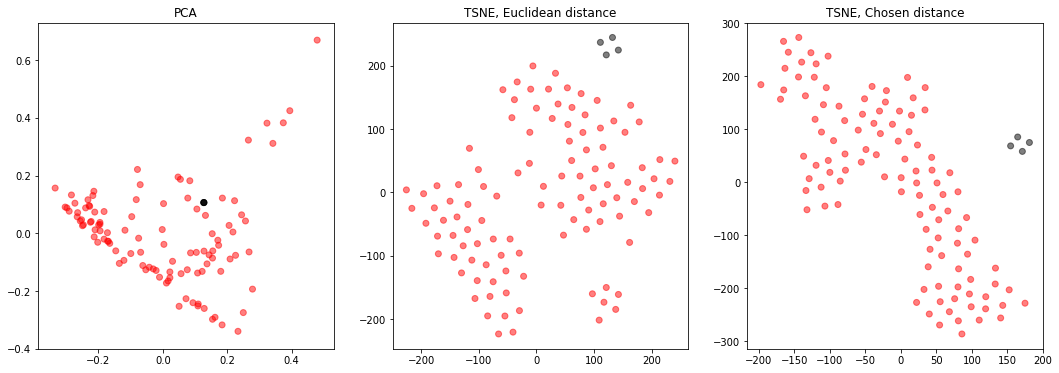

Clustering


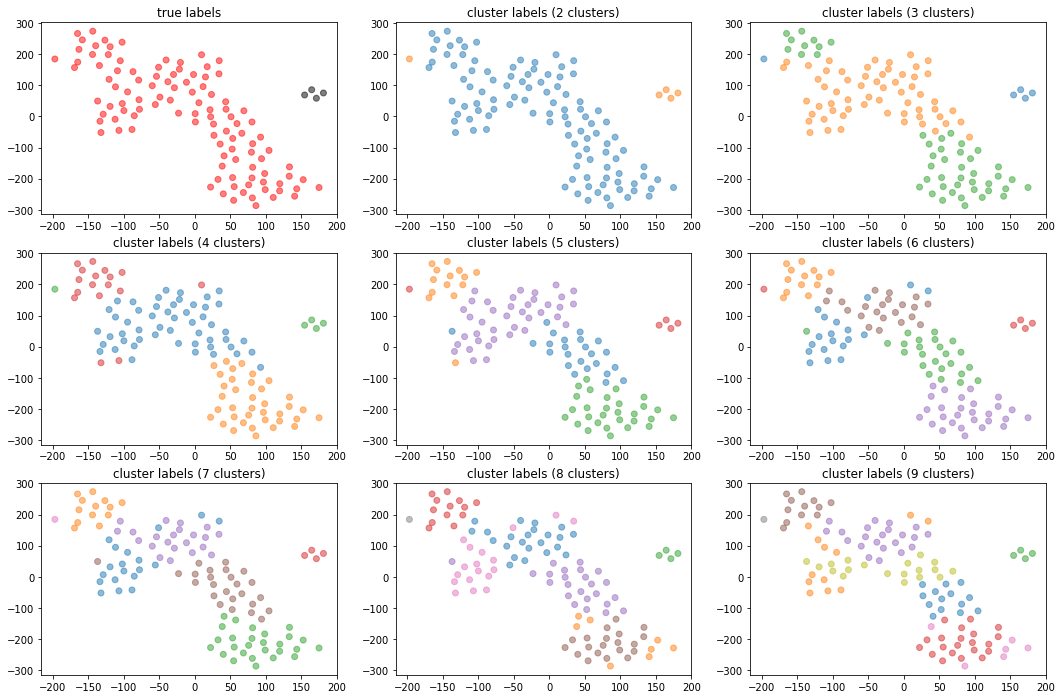

0 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0
13,b' ',b'rdg ',b'',b'hbl',0
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0
26,b' ',b'bll ',b'',b'hbl',0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0
34,b'1FGL J0847.2+1134 ',b'bll ',"b'1FGL J0847.2+113,2FGL J0847.2+1134,3FGL J084...",b'hbl',0
39,b' ',b'PSR ',b'',b'pwn',0
41,b'1FGL J1028.4-5819 ',b'PSR ',b'',b'pwn',0
44,b'1FGL J1119.4-6127c',b'PSR ',b'',b'pwn',0
48,b'1FGL J1221.3+3008 ',b'bll ',b'',b'hbl',0


1 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b' ',b'snr ',b'',b'snr',0
10,b' ',b'bll ',b'',b'hbl',0
16,b' ',b'bll ',b'',b'hbl',0
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0
21,b' ',b' ',b'',"b'snr,mc'",0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0
49,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',0
56,b'1FGL J1325.6-4300 ',b'RDG ',b'',b'fri',0
57,b' ',b'PSR ',b'',b'pwn',0


2 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0
25,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',0
28,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0
32,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',0


3 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
40,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0
90,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1
103,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1


4 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
5,b' ',b'bll ',b'',b'hbl',0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0
24,b' ',b'PWN ',b'',b'pwn',0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0
33,b' ',b'PWN ',b'',b'pwn',0
37,b' ',b'bll ',b'',b'hbl',0
43,b'1FGL J1104.4+3812 ',b'BLL ',b'',b'hbl',0
45,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',0
54,b' ',b'PWN ',b'',b'pwn',0
55,b' ',b'bcu ',b'',b'hbl',0


5 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b' ',b'bll ',b'',b'hbl',0
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0
22,b' ',b'PWN ',b'',b'psr',0
29,b'1FGL J0650.7+2503 ',b'bll ',b'',b'hbl',0
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0
51,b'1FGL J1224.7+2121 ',b'FSRQ ',b'',b'fsrq',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.088580,0.286215,0.180577,0.179095,0.256681,0.0,0.003849,0.001730,0.001480,0.001035,0.000759
1,0.130234,0.064370,0.149414,0.066984,0.105770,0.0,0.152338,0.036202,0.029802,0.057539,0.207346
2,0.166646,0.204173,0.181095,0.207191,0.188201,0.0,0.041051,0.007103,0.003156,0.000977,0.000406
3,0.000011,0.000079,0.000168,0.000040,0.000127,0.0,0.000002,0.000037,0.000585,0.011938,0.187012
4,0.165413,0.111970,0.106722,0.125105,0.097345,0.0,0.150129,0.088708,0.063787,0.048313,0.042507
5,0.139185,0.178832,0.210131,0.149118,0.198320,0.0,0.085043,0.020367,0.009205,0.006785,0.003013


In [8]:
# earth mover's distance
metric_function = st.wasserstein_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
# spectra_distances = get_distance_metric(metric_function).pairwise(spectra[spectrum_columns])
#pd.DataFrame(spectra_distances).to_csv(path_to_gamma_bins +"markeddata/gevtev_spectra_EM_distances.txt", index=False)
build_images(spectra_distances, 700, 1500, 800)
print_clusters_structure(spectra_distances, 6)

* ### euclidean distance

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


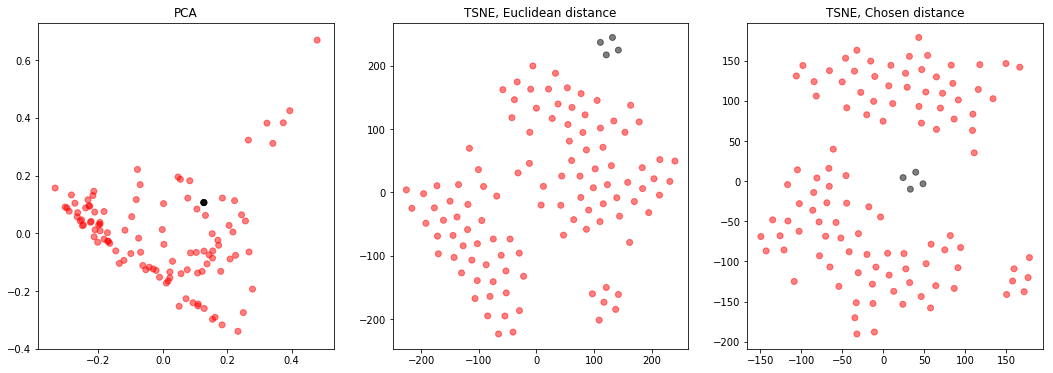

Clustering


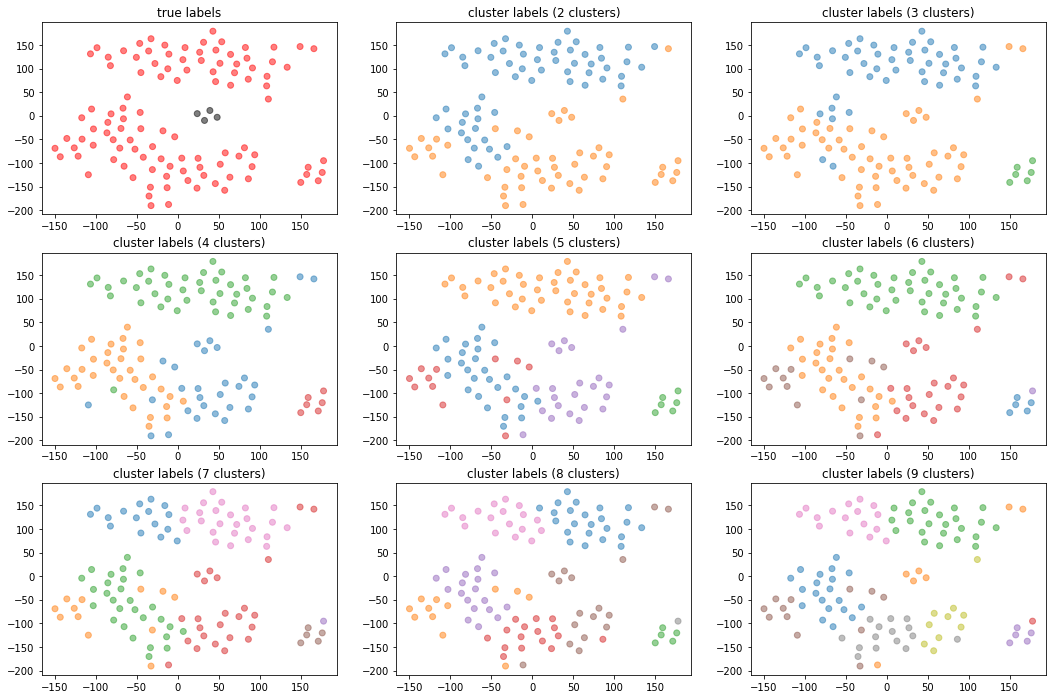

0 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b' ',b'snr ',b'',b'snr',0
16,b' ',b'bll ',b'',b'hbl',0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0
69,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',0


1 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0
32,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',0
43,b'1FGL J1104.4+3812 ',b'BLL ',b'',b'hbl',0
46,b'1FGL J1136.2+6739 ',b'bll ',b'',b'hbl',0


2 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0
25,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0
33,b' ',b'PWN ',b'',b'pwn',0
35,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0
39,b' ',b'PSR ',b'',b'pwn',0


3 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b' ',b'bll ',b'',b'hbl',0
5,b' ',b'bll ',b'',b'hbl',0
10,b' ',b'bll ',b'',b'hbl',0
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0
24,b' ',b'PWN ',b'',b'pwn',0
28,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0
37,b' ',b'bll ',b'',b'hbl',0
40,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1


4 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0


5 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0
13,b' ',b'rdg ',b'',b'hbl',0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0
21,b' ',b' ',b'',"b'snr,mc'",0
22,b' ',b'PWN ',b'',b'psr',0
26,b' ',b'bll ',b'',b'hbl',0
29,b'1FGL J0650.7+2503 ',b'bll ',b'',b'hbl',0
34,b'1FGL J0847.2+1134 ',b'bll ',"b'1FGL J0847.2+113,2FGL J0847.2+1134,3FGL J084...",b'hbl',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.078004,0.041391,0.011833,0.049710,0.049516,0.0,0.080082,0.021528,0.027623,0.120868,0.519444
1,0.214100,0.170681,0.129406,0.205869,0.135061,0.0,0.075842,0.033786,0.020370,0.010534,0.004351
2,0.033906,0.234506,0.269234,0.128472,0.273003,0.0,0.022857,0.013573,0.009910,0.008651,0.005887
3,0.101859,0.071117,0.086843,0.080174,0.070525,0.0,0.223090,0.075972,0.048948,0.036637,0.038167
4,0.000057,0.000393,0.000838,0.000202,0.000636,0.0,0.000009,0.000187,0.002927,0.059691,0.935061
5,0.404133,0.161409,0.043782,0.235443,0.078540,0.0,0.024835,0.014367,0.015857,0.013324,0.008310


In [9]:
# euclidean distance
from scipy.spatial.distance import euclidean
metric_function = "euclidean"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances, 700, 1500, 400)
print_clusters_structure(spectra_distances, 6)

* ### cosine distance

$$ d(u, v) = 1 -  \frac{uv}{||u||_{2}||v||_{2}}$$

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


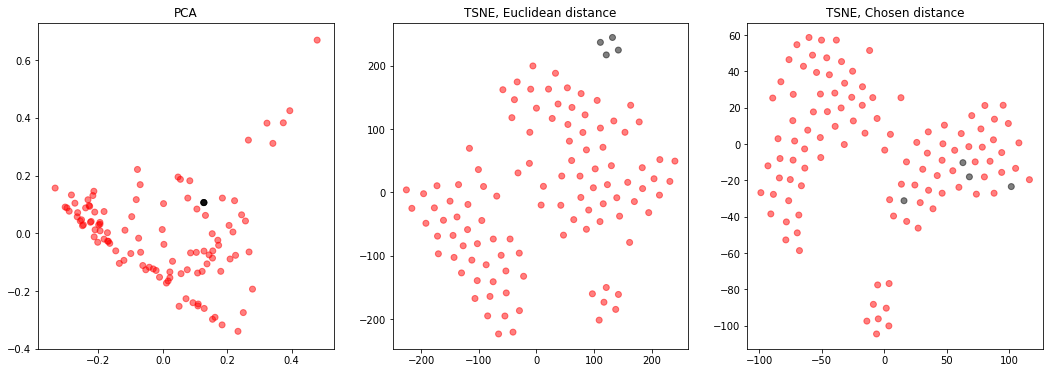

Clustering


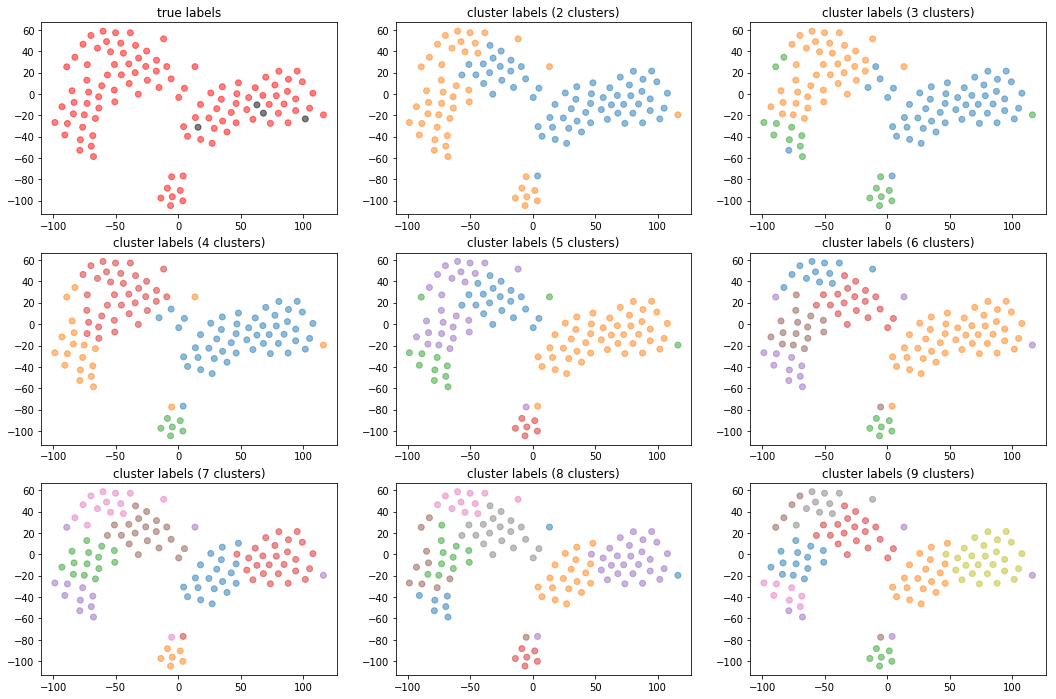

0 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0
35,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
41,b'1FGL J1028.4-5819 ',b'PSR ',b'',b'pwn',0
52,b'1FGL J1230.8+1223 ',b'rdg ',b'',b'fri',0
58,b'1FGL J1418.7-6057 ',b'PSR ',b'',b'pwn',0
59,b'1FGL J1418.7-6057 ',b'PSR ',b'',b'pwn',0
76,b'1FGL J1714.5-3830c',b'snr ',b'',"b'snr,mc'",0
78,b'1FGL J1718.2-3825 ',b'PSR ',b'',b'pwn',0
83,b' ',b' ',b'',b'unid',0


1 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b' ',b'snr ',b'',b'snr',0
16,b' ',b'bll ',b'',b'hbl',0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0
69,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',0


2 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
5,b' ',b'bll ',b'',b'hbl',0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0
24,b' ',b'PWN ',b'',b'pwn',0
28,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0
43,b'1FGL J1104.4+3812 ',b'BLL ',b'',b'hbl',0
45,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',0
72,b'1FGL J1640.8-4634c',b'spp ',b'',b'pwn',0
81,b'1FGL J1744.2+1934 ',b'bll ',b'',b'hbl',0


3 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0
25,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',0
33,b' ',b'PWN ',b'',b'pwn',0
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0
39,b' ',b'PSR ',b'',b'pwn',0
40,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1
44,b'1FGL J1119.4-6127c',b'PSR ',b'',b'pwn',0


4 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b' ',b'bll ',b'',b'hbl',0
10,b' ',b'bll ',b'',b'hbl',0
49,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',0
54,b' ',b'PWN ',b'',b'pwn',0
57,b' ',b'PSR ',b'',b'pwn',0
63,b'1FGL J1443.8+2457 ',b'fsrq ',b'3FGL J1443.9+2502',b'fsrq',0
66,b'1FGL J1513.2-5904 ',b'PSR ',b'',b'pwn',0
67,b'1FGL J1514.7-5917 ',b'PWN ',b'',b'pwn',0
71,b'1FGL J1626.0-4917c',b' ',b'',b'unid',0
75,b'1FGL J1711.7-3944c',b'SNR ',b'',b'snr',0


5 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0
32,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',0
46,b'1FGL J1136.2+6739 ',b'bll ',b'',b'hbl',0
47,b'1FGL J1217.7+3007 ',b'bll ',b'',b'hbl',0


6 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0
13,b' ',b'rdg ',b'',b'hbl',0
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0
21,b' ',b' ',b'',"b'snr,mc'",0
22,b' ',b'PWN ',b'',b'psr',0
26,b' ',b'bll ',b'',b'hbl',0
29,b'1FGL J0650.7+2503 ',b'bll ',b'',b'hbl',0
34,b'1FGL J0847.2+1134 ',b'bll ',"b'1FGL J0847.2+113,2FGL J0847.2+1134,3FGL J084...",b'hbl',0
37,b' ',b'bll ',b'',b'hbl',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.034543,0.287591,0.154641,0.162843,0.276741,0.0,0.012649,0.006399,0.005212,0.005200,0.001551
1,0.065013,0.034558,0.010000,0.041459,0.041369,0.0,0.066737,0.017971,0.023507,0.110672,0.588713
2,0.222731,0.131923,0.042277,0.163071,0.084460,0.0,0.213176,0.078976,0.037185,0.016394,0.009808
3,0.029339,0.158706,0.306875,0.085212,0.224734,0.0,0.026901,0.016293,0.011717,0.011440,0.017671
4,0.068197,0.074148,0.122118,0.075636,0.090565,0.0,0.301242,0.111958,0.078870,0.051441,0.025824
5,0.211460,0.177559,0.166865,0.211891,0.151963,0.0,0.051864,0.012962,0.007328,0.005065,0.003042
6,0.376884,0.155570,0.058572,0.226419,0.080532,0.0,0.011534,0.017238,0.022862,0.024151,0.026239


In [10]:
# cosine distance
# from scipy.spatial.distance import cosine
metric_function = "cosine"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances, 700, 1500, 400)
print_clusters_structure(spectra_distances, 7)

* ### energy distance

The energy distance between two distributions $u$ and $v$ , whose respective CDFs are $U$ and $V$, equals to: 
$$D(u, v) = (2\mathbb{E}|X-Y| - {E}|X-X'| - {E}|Y-Y'|)^{\frac{1}{2}}$$
where $X$ and $Y$ (resp. $X'$  and $Y'$ ) are independent random variables whose probability distribution is  (resp. ).

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


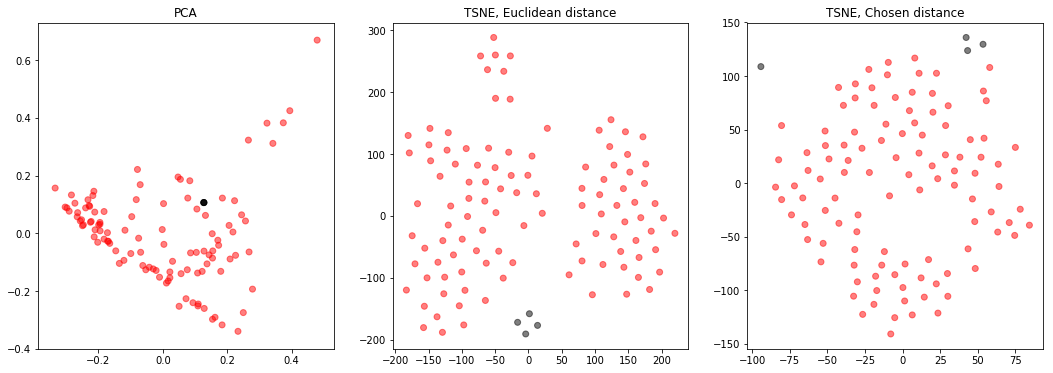

Clustering


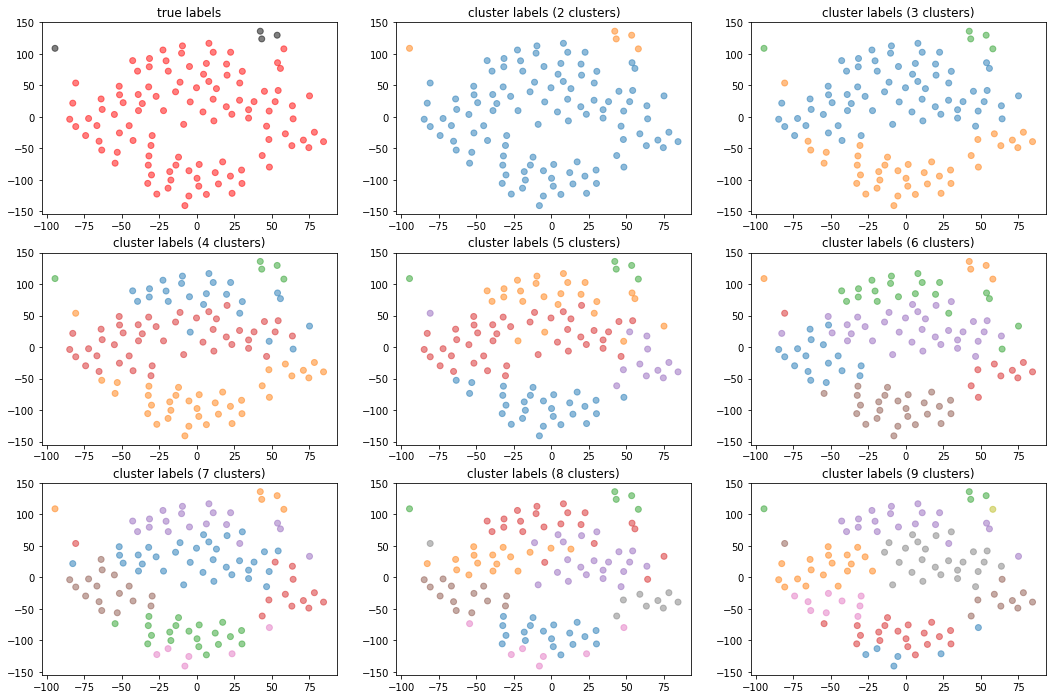

0 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
5,b' ',b'bll ',b'',b'hbl',0
10,b' ',b'bll ',b'',b'hbl',0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0
24,b' ',b'PWN ',b'',b'pwn',0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0
33,b' ',b'PWN ',b'',b'pwn',0
37,b' ',b'bll ',b'',b'hbl',0
43,b'1FGL J1104.4+3812 ',b'BLL ',b'',b'hbl',0
45,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',0
54,b' ',b'PWN ',b'',b'pwn',0


1 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0
13,b' ',b'rdg ',b'',b'hbl',0
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0
22,b' ',b'PWN ',b'',b'psr',0
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0
26,b' ',b'bll ',b'',b'hbl',0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0
34,b'1FGL J0847.2+1134 ',b'bll ',"b'1FGL J0847.2+113,2FGL J0847.2+1134,3FGL J084...",b'hbl',0
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0
39,b' ',b'PSR ',b'',b'pwn',0


2 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
40,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0
90,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1
103,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1


3 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b' ',b'bll ',b'',b'hbl',0
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0


4 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b' ',b'snr ',b'',b'snr',0
16,b' ',b'bll ',b'',b'hbl',0
21,b' ',b' ',b'',"b'snr,mc'",0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0
49,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',0
57,b' ',b'PSR ',b'',b'pwn',0
66,b'1FGL J1513.2-5904 ',b'PSR ',b'',b'pwn',0
69,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',0
73,b' ',b'spp ',b'',b'unid',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.158657,0.108889,0.105789,0.119004,0.097834,0.0,0.159368,0.091114,0.066209,0.049229,0.043907
1,0.116690,0.258258,0.198713,0.174480,0.243132,0.0,0.003538,0.001952,0.001461,0.001007,0.000768
2,0.000011,0.000079,0.000168,0.000040,0.000127,0.0,0.000002,0.000037,0.000585,0.011938,0.187012
3,0.161668,0.188876,0.189598,0.184022,0.184305,0.0,0.069484,0.013757,0.005618,0.001926,0.000746
4,0.086350,0.088720,0.136367,0.065095,0.128514,0.0,0.137317,0.035837,0.029579,0.067472,0.224748


In [11]:
# energy distance
metric_function = st.energy_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 5)

- ### mahalanobis
$$d(u, v) = \sqrt{(u-v)V^{-1}(u+v)^{T}}$$,
V - The inverse of the covariance matrix.

In [12]:
import scipy as sp
from scipy.spatial.distance import mahalanobis
spectra_spectra = spectra[spectra['marked'] != -1]
spectra_spectra = spectra_spectra[spectrum_columns].drop_duplicates()
spectra_no_zeros = spectra.loc[(spectra_spectra!= 0).any(axis=1), :]
spectra_no_zeros2 = spectra_no_zeros.loc[:, (spectra_no_zeros != 0).any(axis=0)]
new_columns = [i for i in spectra_no_zeros2 if i in spectrum_columns]
covmx = spectra_no_zeros2[new_columns].cov()
invcovmx = sp.linalg.inv(covmx)

In [13]:
#func = lambda x, y : mahalanobis(x, y, invcovmx)

2.9103445412064866e-13


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


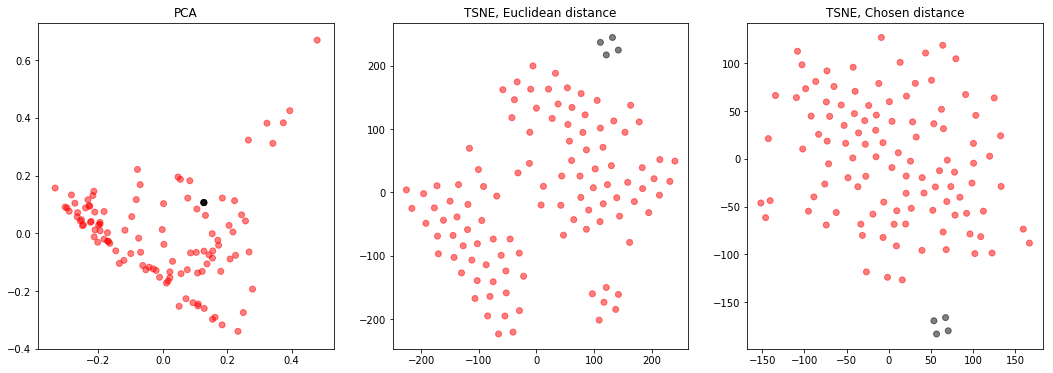

Clustering


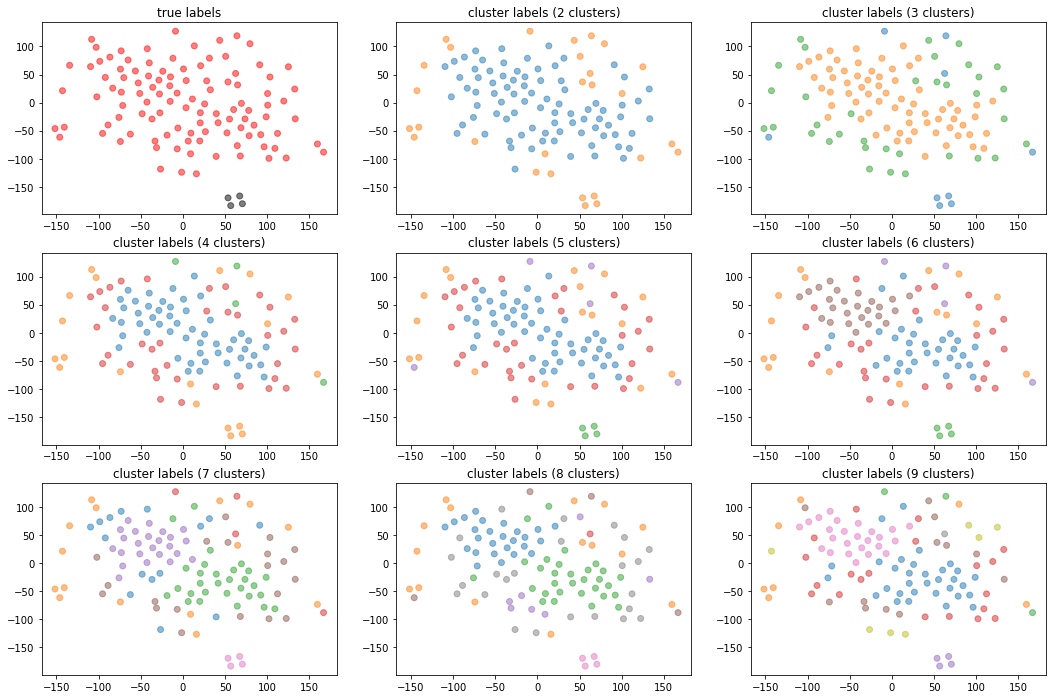

0 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0
25,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0
39,b' ',b'PSR ',b'',b'pwn',0
41,b'1FGL J1028.4-5819 ',b'PSR ',b'',b'pwn',0


1 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b' ',b'bll ',b'',b'hbl',0
1,b' ',b'snr ',b'',b'snr',0
10,b' ',b'bll ',b'',b'hbl',0
16,b' ',b'bll ',b'',b'hbl',0
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0
21,b' ',b' ',b'',"b'snr,mc'",0
26,b' ',b'bll ',b'',b'hbl',0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0


2 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
40,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1
90,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1
103,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1


3 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
5,b' ',b'bll ',b'',b'hbl',0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0
24,b' ',b'PWN ',b'',b'pwn',0
28,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',0
33,b' ',b'PWN ',b'',b'pwn',0
35,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
37,b' ',b'bll ',b'',b'hbl',0
43,b'1FGL J1104.4+3812 ',b'BLL ',b'',b'hbl',0
45,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',0


4 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
13,b' ',b'rdg ',b'',b'hbl',0
54,b' ',b'PWN ',b'',b'pwn',0
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0
80,b'1FGL J1727.9+5010 ',b'bll ',b'',b'hbl',0


5 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0
22,b' ',b'PWN ',b'',b'psr',0
29,b'1FGL J0650.7+2503 ',b'bll ',b'',b'hbl',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,3.716634e-02,2.299398e-01,2.659244e-01,1.366761e-01,2.695284e-01,0.0,2.471541e-02,9.790942e-03,7.148143e-03,7.148608e-03,1.196175e-02
1,1.690815e-01,9.704805e-02,5.284685e-02,1.044546e-01,8.425015e-02,0.0,1.467309e-01,6.323342e-02,4.725383e-02,6.466874e-02,1.704319e-01
2,3.215007e-12,5.619456e-11,8.141391e-11,2.608559e-11,7.814144e-11,0.0,1.168251e-11,8.652169e-12,6.238473e-12,3.270584e-12,1.320502e-12
3,1.232668e-01,1.505212e-01,1.614398e-01,1.313671e-01,1.474462e-01,0.0,1.511666e-01,5.462623e-02,3.455675e-02,2.415417e-02,2.145514e-02
4,1.140084e-01,1.477313e-01,2.423787e-02,1.230071e-01,4.039349e-02,0.0,7.598749e-02,9.163138e-02,7.433727e-02,6.398984e-02,2.446759e-01
5,2.789908e-01,1.712391e-01,1.257950e-01,2.231547e-01,1.345371e-01,0.0,4.560956e-02,1.068476e-02,6.048991e-03,2.732371e-03,1.207707e-03


In [14]:
plt.clf()
metric_function = "mahalanobis"
min_element = np.min(spectra_no_zeros2[new_columns].values[(np.nonzero(spectra_no_zeros2[new_columns].values))])
print(min_element)
noise = pd.DataFrame(data = np.random.randn(spectra_no_zeros2[new_columns].shape[0], spectra_no_zeros2[new_columns].shape[1]), columns = new_columns)
m = spectra_no_zeros2[new_columns] + min_element*noise
spectra_distances = pairwise_distances(m, metric=metric_function)
build_images(spectra_distances, 700, 1500, 400)
print_clusters_structure(spectra_distances, 6)

- ### canberra
$$d(u, v) = \sum_{i} \frac{|u_i - v_i|}{|u_i| + |v_i|}$$

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


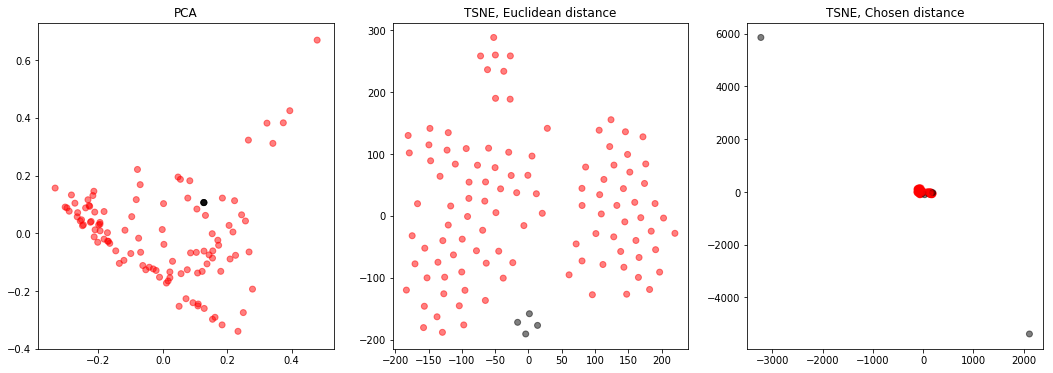

Clustering


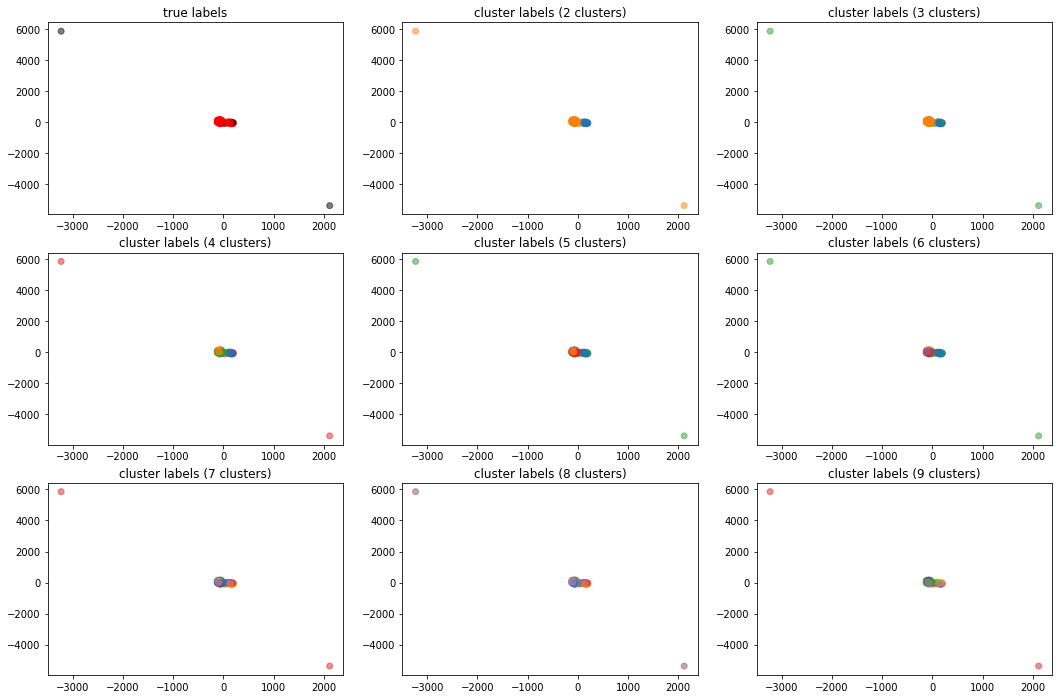

0 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0
13,b' ',b'rdg ',b'',b'hbl',0
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0
22,b' ',b'PWN ',b'',b'psr',0


1 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b' ',b'bll ',b'',b'hbl',0
5,b' ',b'bll ',b'',b'hbl',0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0
21,b' ',b' ',b'',"b'snr,mc'",0
24,b' ',b'PWN ',b'',b'pwn',0
28,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',0
43,b'1FGL J1104.4+3812 ',b'BLL ',b'',b'hbl',0
45,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',0
49,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',0


2 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
40,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0
90,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1
103,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1


3 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0
25,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0
32,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',0
41,b'1FGL J1028.4-5819 ',b'PSR ',b'',b'pwn',0
47,b'1FGL J1217.7+3007 ',b'bll ',b'',b'hbl',0
51,b'1FGL J1224.7+2121 ',b'FSRQ ',b'',b'fsrq',0


4 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b' ',b'snr ',b'',b'snr',0
10,b' ',b'bll ',b'',b'hbl',0
16,b' ',b'bll ',b'',b'hbl',0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0
33,b' ',b'PWN ',b'',b'pwn',0
37,b' ',b'bll ',b'',b'hbl',0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0
54,b' ',b'PWN ',b'',b'pwn',0
57,b' ',b'PSR ',b'',b'pwn',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.180579,0.222250,0.197688,0.197711,0.201772,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.189631,0.134145,0.076062,0.155870,0.098418,0.0,0.190061,0.078716,0.042692,0.022606,0.011799
2,0.000011,0.000079,0.000168,0.000040,0.000127,0.0,0.000002,0.000037,0.000585,0.011938,0.187012
3,0.078350,0.207540,0.228737,0.145281,0.236626,0.0,0.059269,0.015682,0.008722,0.008084,0.011710
4,0.110559,0.050785,0.093455,0.054076,0.068625,0.0,0.169659,0.076912,0.074053,0.093753,0.208124


In [15]:
metric_function = "canberra"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 5)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


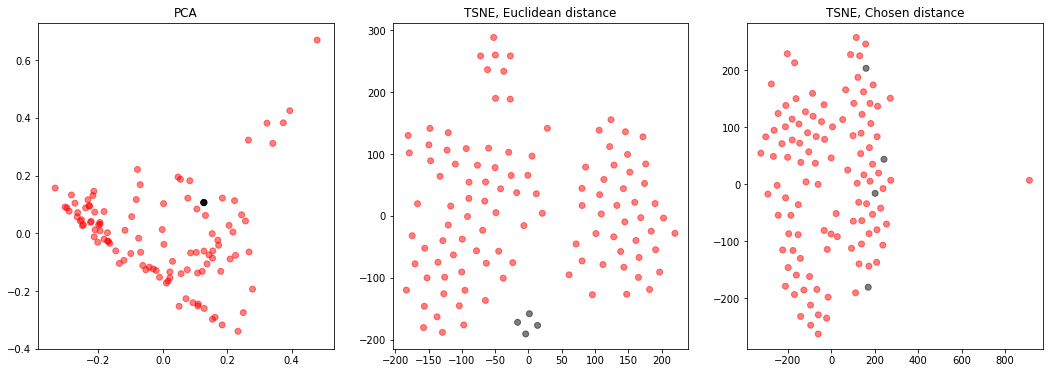

Clustering


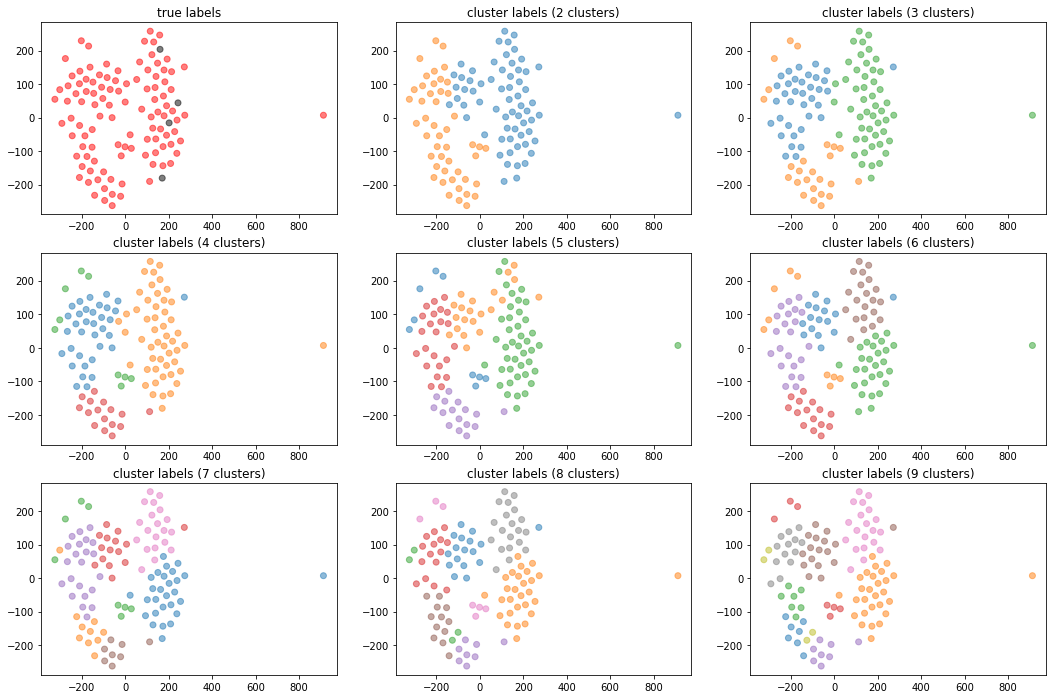

0 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b' ',b'snr ',b'',b'snr',0
16,b' ',b'bll ',b'',b'hbl',0
37,b' ',b'bll ',b'',b'hbl',0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0
54,b' ',b'PWN ',b'',b'pwn',0
61,b'1FGL J1428.7+4239 ',b'bll ',b'',b'hbl',0
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0
69,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',0


1 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0
32,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',0
46,b'1FGL J1136.2+6739 ',b'bll ',b'',b'hbl',0
47,b'1FGL J1217.7+3007 ',b'bll ',b'',b'hbl',0


2 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0
25,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0
33,b' ',b'PWN ',b'',b'pwn',0
35,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0


3 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0
13,b' ',b'rdg ',b'',b'hbl',0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0
21,b' ',b' ',b'',"b'snr,mc'",0
22,b' ',b'PWN ',b'',b'psr',0
26,b' ',b'bll ',b'',b'hbl',0
28,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',0
29,b'1FGL J0650.7+2503 ',b'bll ',b'',b'hbl',0


4 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b' ',b'bll ',b'',b'hbl',0
5,b' ',b'bll ',b'',b'hbl',0
10,b' ',b'bll ',b'',b'hbl',0
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0
24,b' ',b'PWN ',b'',b'pwn',0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0
45,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',0
49,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',0
57,b' ',b'PSR ',b'',b'pwn',0
63,b'1FGL J1443.8+2457 ',b'fsrq ',b'3FGL J1443.9+2502',b'fsrq',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.124318,0.044078,0.024232,0.053977,0.041981,0.0,0.059290,0.039178,0.059586,0.118697,0.434665
1,0.176328,0.201750,0.146943,0.206948,0.166169,0.0,0.039963,0.007746,0.003079,0.001896,0.001559
2,0.031006,0.205260,0.263186,0.111142,0.250630,0.0,0.022565,0.013343,0.009814,0.009650,0.011974
3,0.312970,0.160107,0.054071,0.222191,0.090456,0.0,0.080815,0.038270,0.024411,0.012239,0.004470
4,0.109183,0.081755,0.108138,0.088740,0.086487,0.0,0.308378,0.103136,0.056762,0.034874,0.022547


In [16]:
metric_function = "correlation"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 5)

- ### cityblock
$$ d(u, v) = \sum_{i} |u_i - v_i|$$

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


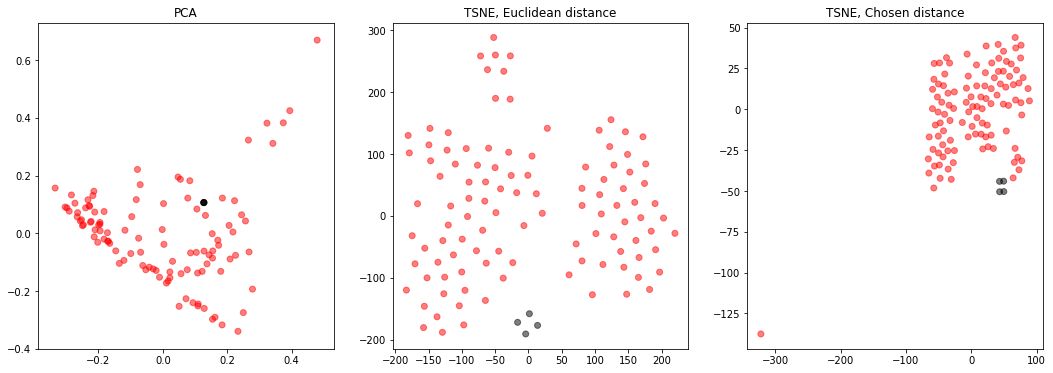

Clustering


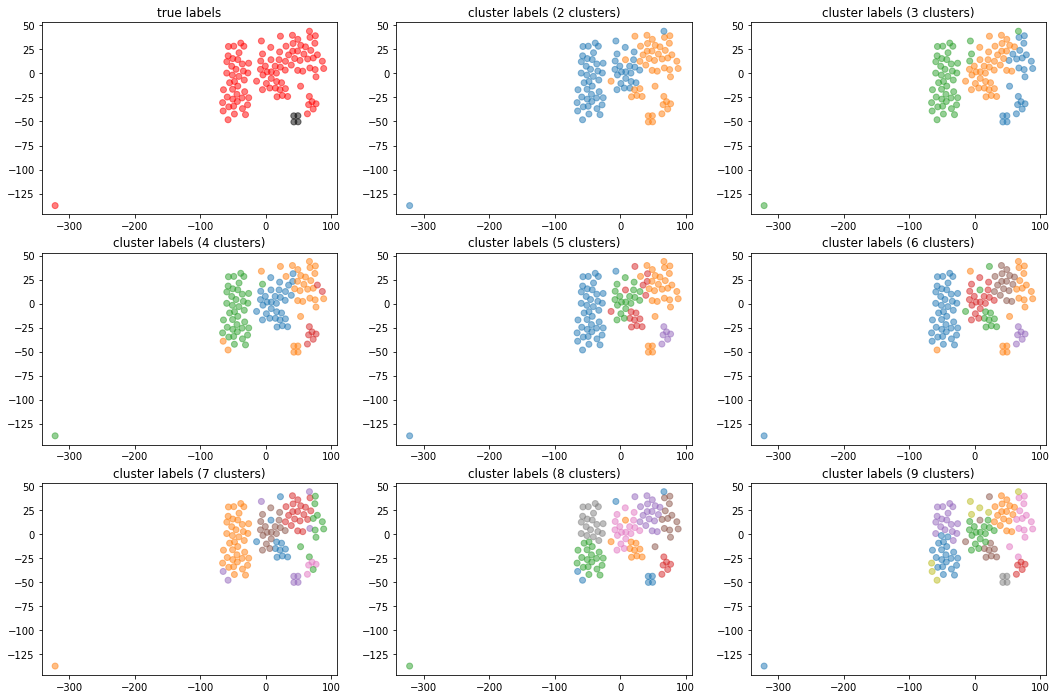

0 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0
25,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0
33,b' ',b'PWN ',b'',b'pwn',0
35,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0
39,b' ',b'PSR ',b'',b'pwn',0


1 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b' ',b'bll ',b'',b'hbl',0
5,b' ',b'bll ',b'',b'hbl',0
10,b' ',b'bll ',b'',b'hbl',0
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0
24,b' ',b'PWN ',b'',b'pwn',0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0
37,b' ',b'bll ',b'',b'hbl',0
40,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1


2 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0
32,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',0
46,b'1FGL J1136.2+6739 ',b'bll ',b'',b'hbl',0
47,b'1FGL J1217.7+3007 ',b'bll ',b'',b'hbl',0


3 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0
13,b' ',b'rdg ',b'',b'hbl',0
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0
21,b' ',b' ',b'',"b'snr,mc'",0
22,b' ',b'PWN ',b'',b'psr',0
26,b' ',b'bll ',b'',b'hbl',0
28,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',0
29,b'1FGL J0650.7+2503 ',b'bll ',b'',b'hbl',0
34,b'1FGL J0847.2+1134 ',b'bll ',"b'1FGL J0847.2+113,2FGL J0847.2+1134,3FGL J084...",b'hbl',0


4 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b' ',b'snr ',b'',b'snr',0
16,b' ',b'bll ',b'',b'hbl',0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0
69,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.034487,0.232126,0.267234,0.128446,0.269665,0.0,0.023016,0.013369,0.009890,0.009706,0.012062
1,0.131224,0.079832,0.072376,0.092576,0.068865,0.0,0.205033,0.086246,0.058326,0.039870,0.027721
2,0.211460,0.177559,0.166865,0.211891,0.151963,0.0,0.051864,0.012962,0.007328,0.005065,0.003042
3,0.360499,0.173302,0.051894,0.245051,0.093306,0.0,0.054325,0.012623,0.006376,0.001913,0.000710
4,0.065013,0.034558,0.010000,0.041459,0.041369,0.0,0.066737,0.017971,0.023507,0.110672,0.588713


In [17]:
metric_function = "cityblock"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 5)

- ### braycurtis 
$$d(u, v) = \frac{\sum_{i} |u_i - v_i|}{\sum_{i}|u_i + v_i|}$$

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


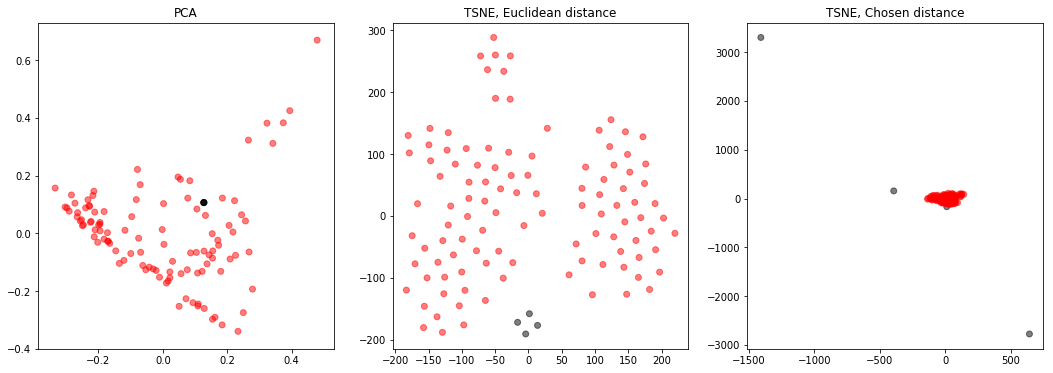

Clustering


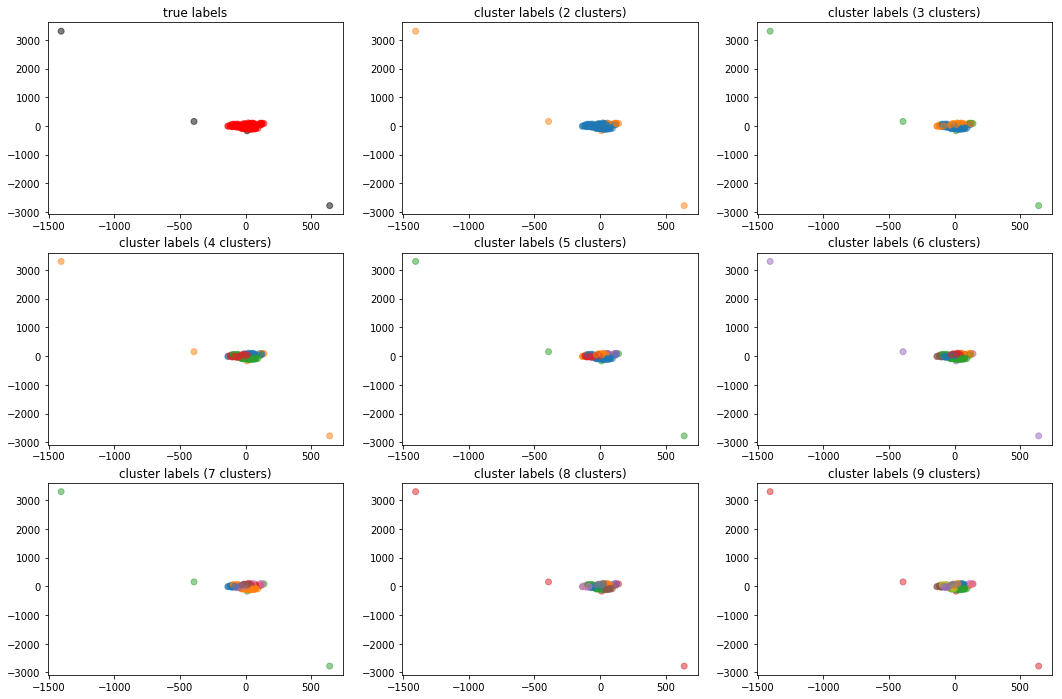

0 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0
13,b' ',b'rdg ',b'',b'hbl',0
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0
21,b' ',b' ',b'',"b'snr,mc'",0
22,b' ',b'PWN ',b'',b'psr',0
26,b' ',b'bll ',b'',b'hbl',0
29,b'1FGL J0650.7+2503 ',b'bll ',b'',b'hbl',0
34,b'1FGL J0847.2+1134 ',b'bll ',"b'1FGL J0847.2+113,2FGL J0847.2+1134,3FGL J084...",b'hbl',0
48,b'1FGL J1221.3+3008 ',b'bll ',b'',b'hbl',0


1 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0
25,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0
35,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0
39,b' ',b'PSR ',b'',b'pwn',0
41,b'1FGL J1028.4-5819 ',b'PSR ',b'',b'pwn',0


2 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
40,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0
90,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1
103,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1


3 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b' ',b'bll ',b'',b'hbl',0
33,b' ',b'PWN ',b'',b'pwn',0
49,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',0
55,b' ',b'bcu ',b'',b'hbl',0
57,b' ',b'PSR ',b'',b'pwn',0
63,b'1FGL J1443.8+2457 ',b'fsrq ',b'3FGL J1443.9+2502',b'fsrq',0
66,b'1FGL J1513.2-5904 ',b'PSR ',b'',b'pwn',0
68,b'1FGL J1517.8-2423 ',b'bll ',b'',b'lbl',0
71,b'1FGL J1626.0-4917c',b' ',b'',b'unid',0
80,b'1FGL J1727.9+5010 ',b'bll ',b'',b'hbl',0


4 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0
32,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',0
46,b'1FGL J1136.2+6739 ',b'bll ',b'',b'hbl',0
47,b'1FGL J1217.7+3007 ',b'bll ',b'',b'hbl',0


5 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b' ',b'bll ',b'',b'hbl',0
5,b' ',b'bll ',b'',b'hbl',0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0
24,b' ',b'PWN ',b'',b'pwn',0
28,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0
37,b' ',b'bll ',b'',b'hbl',0
43,b'1FGL J1104.4+3812 ',b'BLL ',b'',b'hbl',0
45,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',0


6 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b' ',b'snr ',b'',b'snr',0
16,b' ',b'bll ',b'',b'hbl',0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0
54,b' ',b'PWN ',b'',b'pwn',0
61,b'1FGL J1428.7+4239 ',b'bll ',b'',b'hbl',0
67,b'1FGL J1514.7-5917 ',b'PWN ',b'',b'pwn',0
69,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',0
75,b'1FGL J1711.7-3944c',b'SNR ',b'',b'snr',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.407458,0.176917,0.054981,0.256366,0.091373,0.0,0.002740,0.003302,0.003914,0.002056,0.000893
1,0.033450,0.239563,0.268417,0.132135,0.279353,0.0,0.020915,0.010674,0.007233,0.005452,0.002809
2,0.000011,0.000079,0.000168,0.000040,0.000127,0.0,0.000002,0.000037,0.000585,0.011938,0.187012
3,0.041337,0.086400,0.199231,0.065961,0.120529,0.0,0.250580,0.085881,0.052185,0.042699,0.055197
4,0.211400,0.181789,0.167079,0.211937,0.156413,0.0,0.048709,0.011257,0.005751,0.003755,0.001908
5,0.213548,0.127798,0.053435,0.167261,0.075808,0.0,0.199771,0.074743,0.039370,0.024433,0.023833
6,0.130983,0.048056,0.010762,0.056140,0.050200,0.0,0.115390,0.073399,0.085388,0.120097,0.309585


In [18]:
metric_function = "braycurtis"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances)
print_clusters_structure(spectra_distances, 7)

- ### corellation 
$$d(u, v) = 1 -  \frac{(u - \overline{u}) \cdot (v - \overline{v})}{||(u - \overline{u})||_{2} \cdot  ||(v - \overline{v})||_{2}}$$

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


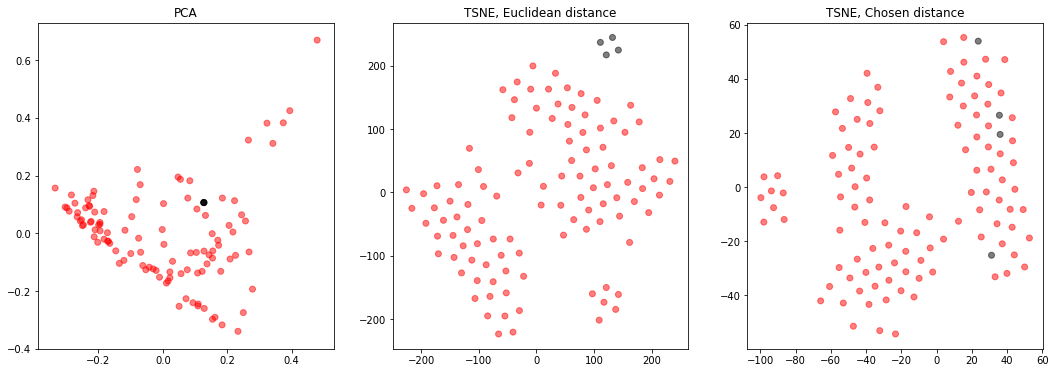

Clustering


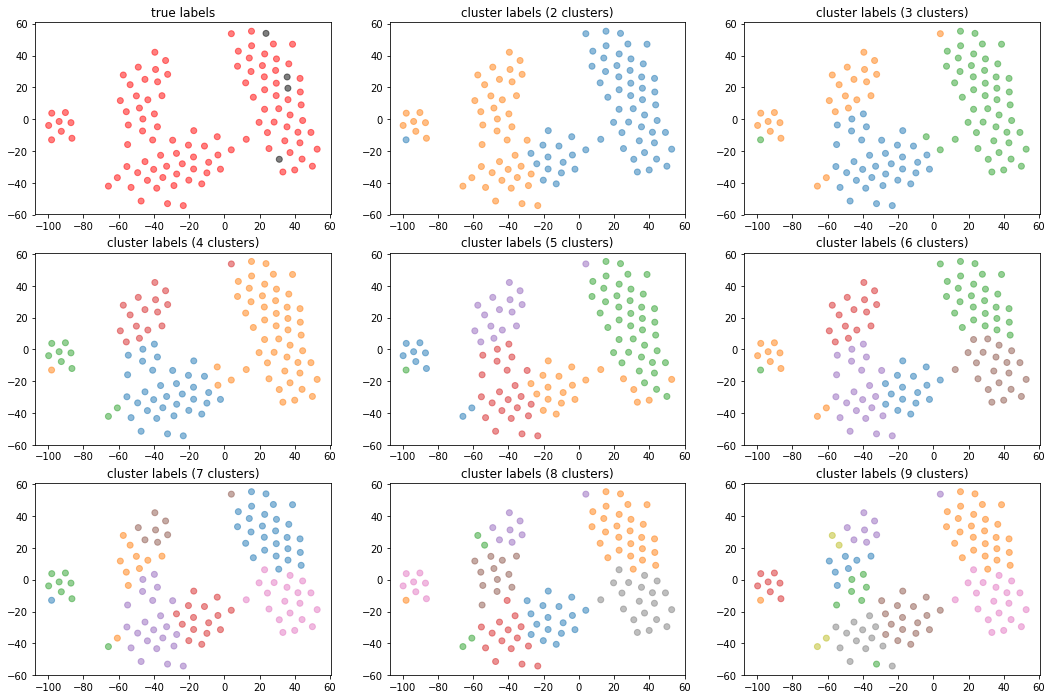

0 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
3,b'1FGL J0035.9+5951 ',b'bll ',b'',b'hbl',0
8,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'ibl',0
9,b'1FGL J0222.6+4302 ',b'BLL ',b'',b'unid',0
12,b'1FGL J0303.5-2406 ',b'BLL ',b'',b'hbl',0
18,b'1FGL J0449.5-4350 ',b'bll ',b'',b'hbl',0
20,b'1FGL J0521.7+2114 ',b'bll ',b'',b'ibl',0
32,b'1FGL J0809.5+5219 ',b'bll ',b'',b'hbl',0
46,b'1FGL J1136.2+6739 ',b'bll ',b'',b'hbl',0
47,b'1FGL J1217.7+3007 ',b'bll ',b'',b'hbl',0
50,b' ',b'bll ',b'',b'hbl',0


1 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
6,b'1FGL J0205.6+6449 ',b'PSR ',b'',b'pwn',0
7,b'1FGL J0221.0+3555 ',b'FSRQ ',b'',b'blazar',0
11,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
23,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'psr',0
25,b'1FGL J0534.5+2200 ',b'PSR ',b'',b'pwn',0
33,b' ',b'PWN ',b'',b'pwn',0
36,b'1FGL J1000.1+6539 ',b'bll ',b'',b'blazar',0
39,b' ',b'PSR ',b'',b'pwn',0
40,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1
44,b'1FGL J1119.4-6127c',b'PSR ',b'',b'pwn',0


2 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
54,b' ',b'PWN ',b'',b'pwn',0
61,b'1FGL J1428.7+4239 ',b'bll ',b'',b'hbl',0
67,b'1FGL J1514.7-5917 ',b'PWN ',b'',b'pwn',0
75,b'1FGL J1711.7-3944c',b'SNR ',b'',b'snr',0


3 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'1FGL J0033.5-1921 ',b'bll ',b'',b'hbl',0
4,b'1FGL J0136.5+3905 ',b'bll ',b'',b'hbl',0
13,b' ',b'rdg ',b'',b'hbl',0
19,b'1FGL J0507.9+6738 ',b'bll ',b'',b'hbl',0
21,b' ',b' ',b'',"b'snr,mc'",0
22,b' ',b'PWN ',b'',b'psr',0
26,b' ',b'bll ',b'',b'hbl',0
29,b'1FGL J0650.7+2503 ',b'bll ',b'',b'hbl',0
34,b'1FGL J0847.2+1134 ',b'bll ',"b'1FGL J0847.2+113,2FGL J0847.2+1134,3FGL J084...",b'hbl',0
48,b'1FGL J1221.3+3008 ',b'bll ',b'',b'hbl',0


4 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b' ',b'bll ',b'',b'hbl',0
49,b'1FGL J1221.5+2814 ',b'bll ',b'',b'ibl',0
57,b' ',b'PSR ',b'',b'pwn',0
63,b'1FGL J1443.8+2457 ',b'fsrq ',b'3FGL J1443.9+2502',b'fsrq',0
66,b'1FGL J1513.2-5904 ',b'PSR ',b'',b'pwn',0
71,b'1FGL J1626.0-4917c',b' ',b'',b'unid',0
80,b'1FGL J1727.9+5010 ',b'bll ',b'',b'hbl',0
105,b'1FGL J2202.8+4216 ',b'BLL ',b'',b'lbl',0


5 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b' ',b'bll ',b'',b'hbl',0
5,b' ',b'bll ',b'',b'hbl',0
15,b'1FGL J0319.7+1847 ',b'bll ',b'',b'hbl',0
17,b'1FGL J0416.8+0107 ',b'bll ',b'',b'hbl',0
24,b' ',b'PWN ',b'',b'pwn',0
28,b'1FGL J0648.8+1516 ',b'bll ',b'1FGL J0648.8+1516',b'hbl',0
30,b'1FGL J0710.6+5911 ',b'bll ',b'1FGL J0710.6+5911',b'hbl',0
43,b'1FGL J1104.4+3812 ',b'BLL ',b'',b'hbl',0
45,b'1FGL J1136.6+7009 ',b'bll ',b'',b'hbl',0
72,b'1FGL J1640.8-4634c',b'spp ',b'',b'pwn',0


6 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b' ',b'snr ',b'',b'snr',0
16,b' ',b'bll ',b'',b'hbl',0
37,b' ',b'bll ',b'',b'hbl',0
38,b'1FGL J1015.1+4927 ',b'bll ',b'',b'hbl',0
42,b'1FGL J1103.7-2329 ',b'bll ',b'',b'hbl',0
65,b'1FGL J1512.8-0906 ',b'FSRQ ',b'',b'fsrq',0
69,b'1FGL J1555.7+1111 ',b'BLL ',b'',b'hbl',0


7 cluster


,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
14,b'1FGL J0319.7+4130 ',b'RDG ',b'',b'fri',0
27,b'1FGL J0633.9+1746 ',b'PSR ',b'',"b'psr,pwn'",0
31,b'1FGL J0721.9+7120 ',b'BLL ',b'',b'ibl',0
35,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
41,b'1FGL J1028.4-5819 ',b'PSR ',b'',b'pwn',0
52,b'1FGL J1230.8+1223 ',b'rdg ',b'',b'fri',0
58,b'1FGL J1418.7-6057 ',b'PSR ',b'',b'pwn',0
59,b'1FGL J1418.7-6057 ',b'PSR ',b'',b'pwn',0
78,b'1FGL J1718.2-3825 ',b'PSR ',b'',b'pwn',0
83,b' ',b' ',b'',b'unid',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.226192,0.175858,0.169025,0.216651,0.147460,0.0,0.044091,0.009864,0.005550,0.003592,0.001717
1,0.028830,0.161740,0.305570,0.087839,0.226383,0.0,0.026361,0.016210,0.011547,0.011192,0.017184
2,0.197207,0.056389,0.009423,0.064177,0.051054,0.0,0.159524,0.138238,0.157594,0.119134,0.047262
3,0.355002,0.172150,0.050175,0.242502,0.089944,0.0,0.030301,0.024907,0.019475,0.011571,0.003973
4,0.038846,0.068008,0.179501,0.060515,0.111834,0.0,0.325675,0.099937,0.055089,0.034330,0.026266
5,0.214479,0.126181,0.041766,0.155031,0.078538,0.0,0.249066,0.079215,0.032892,0.014175,0.008657
6,0.086380,0.036567,0.029970,0.052930,0.036341,0.0,0.067781,0.017385,0.024319,0.107731,0.540596
7,0.040686,0.280230,0.148243,0.163905,0.268383,0.0,0.023221,0.009310,0.006848,0.006474,0.002702


In [19]:
metric_function = "correlation"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images(spectra_distances, 700, 1500, 400)
print_clusters_structure(spectra_distances, 8)